<a href="https://colab.research.google.com/github/hurshd0/DS-Unit-2-Kaggle-Challenge/blob/master/module2/assignment_kaggle_challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [X] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [X] Continue to participate in our Kaggle challenge.
- [X] Try Ordinal Encoding.
- [X] Try a Random Forest Classifier.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [X] Add your own stretch goal(s) !
- [X] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [X] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [X] Get and plot your feature importances.
- [X] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    # Remove content files
    !rm -rf content
    !mkdir content
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/hurshd0/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master

# Change into directory for module
!rm -rf eda.py
!wget https://raw.githubusercontent.com/hurshd0/ds-cheat-sheets/master/eda.py

--2019-08-15 20:09:57--  https://raw.githubusercontent.com/hurshd0/ds-cheat-sheets/master/eda.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17454 (17K) [text/plain]
Saving to: ‘eda.py’

eda.py              100%[===================>]  17.04K  --.-KB/s    in 0.01s   

2019-08-15 20:09:57 (1.57 MB/s) - ‘eda.py’ saved [17454/17454]



# IMPORTS

In [2]:
################################ EDA IMPORTS ###################################
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objs as go # interactive low-level plotting lib https://plot.ly/python/
# import plotly.express as px #high-level api wrapper for plotly https://plot.ly/python/plotly-express/#visualize-distributions
# ---------------- Plot libs settings ------------- #
plt.style.use('seaborn-darkgrid')
sns.set(context='notebook', style='darkgrid', palette='colorblind')
# Seting a universal figure size 
plt.rcParams['figure.figsize'] = (10, 6)

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# --------------------- Custom lib imports --------------#
import eda

# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

#################################### ML IMPORTS ################################
### Pre-Processing
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

### Train/Test - Split & CV
from sklearn.model_selection import train_test_split

### Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Post-processing
from sklearn.pipeline import make_pipeline

################################################################################

## Quick Helper Functions

In [3]:
def kaggle_submission(model, X_test, submission):
    import datetime, sys
    in_colab = 'google.colab' in sys.modules
    y_pred = model.predict(X_test)
    submission['status_group'] = y_pred
    file_name = 'submission-{}.csv'.format(datetime.datetime.now().strftime('%Y-%m-%d'))
    submission.to_csv(file_name, index=False)
    if in_colab:
        from google.colab import files
        # Just try again if you get this error:
        # TypeError: Failed to fetch
        # https://github.com/googlecolab/colabtools/issues/337
        try:
            files.download(file_name)
        except Exception as e:
            print('Try it again if you get: Type Error: NetworkError when attempting to fetch resource.')
            print(e)

# LOAD DATA

In [4]:
def load_dataset():
    train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
    test = pd.read_csv('../data/tanzania/test_features.csv')
    sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')
    print(f'''
    -------------------- SHAPE ---------------------
    Train Set: {train.shape}
    Test Set: {test.shape}
    Sample Submission: {sample_submission.shape}
    ------------------------------------------------
    ''')
    return (train, test, sample_submission)
traindf, testdf, sampledf = load_dataset()


    -------------------- SHAPE ---------------------
    Train Set: (59400, 41)
    Test Set: (14358, 40)
    Sample Submission: (14358, 2)
    ------------------------------------------------
    


# Random forest 🌾🌴🏝🌲🌳🍀

# No Wrangling Model

![](https://peterdewit.files.wordpress.com/2014/10/heartbeat3.jpg)

In [5]:
traindf.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### @ Ordinal Encoder, Imputing - Median, No Class Weight

------- SHAPE - After Train/Val SPLIT ---------
Training Set: (47520, 41)
Validation Set: (11880, 41)
------- SHAPE - X_train/X_val/X_test SPLIT ---------
Training Set: (47520, 40)
Validation Set: (11880, 40)
Testing Set: (14358, 40)
-------- TRAIN SET --------
Accuracy Score: 0.9862
                         Precision    Recall   F Score  Support
functional                0.978829  0.997908  0.988276    25807
non functional            0.991104  0.935437  0.962466     3454
functional needs repair   0.995989  0.979134  0.987489    18259
-------- VAL SET --------
Accuracy Score: 0.7880
                         Precision    Recall   F Score  Support
functional                0.785508  0.885462  0.832495     6452
non functional            0.497951  0.281576  0.359734      863
functional needs repair   0.826657  0.745893  0.784201     4565
Normalized confusion matrix
[[0.88546187 0.02634842 0.08818971]
 [0.55040556 0.2815759  0.16801854]
 [0.23767798 0.01642935 0.74589266]]


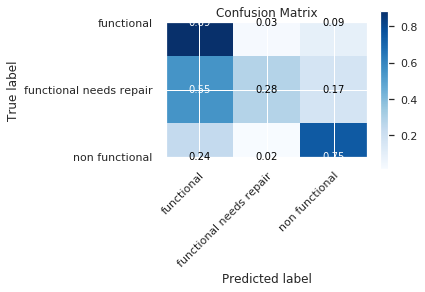

In [6]:
# Split train into train & val
train, val = train_test_split(traindf, train_size=0.80, test_size=0.20, 
                              stratify=traindf['status_group'], random_state=42)
eda.print_shape(train, val, title='After Train/Val SPLIT')

# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = testdf

eda.print_shape(X_train, X_val, X_test, title='X_train/X_val/X_test SPLIT')

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
y_pred = pipeline.predict(X_val)
eda.get_acc_rec_fone(y_val, y_pred, verbose=True, title='VAL')
y_pred = pipeline.predict(X_val)
eda.plot_confusion_matrix(y_val, y_pred, classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')

In [7]:
X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe


### @ Ordinal Encoder, Imputing - Median, With Class Weight

-------- TRAIN SET --------
Accuracy Score: 1.0000
                         Precision  Recall  F Score  Support
functional                     1.0     1.0      1.0    25807
non functional                 1.0     1.0      1.0     3454
functional needs repair        1.0     1.0      1.0    18259
-------- VAL SET --------
Accuracy Score: 0.8120
                         Precision    Recall   F Score  Support
functional                0.795268  0.916925  0.851775     6452
non functional            0.622024  0.242178  0.348624      863
functional needs repair   0.857978  0.771522  0.812457     4565
Normalized confusion matrix
[[0.91692498 0.01255425 0.07052077]
 [0.60950174 0.24217845 0.14831981]
 [0.21840088 0.01007667 0.77152245]]


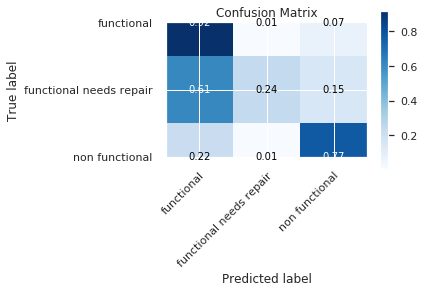

In [8]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=800, random_state=42, n_jobs=-1, class_weight='balanced')
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
y_pred = pipeline.predict(X_val)
eda.get_acc_rec_fone(y_val, y_pred, verbose=True, title='VAL')
y_pred = pipeline.predict(X_val)
eda.plot_confusion_matrix(y_val, y_pred, classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')

### @ Ordinal Encoder, Imputing - Mean, No Class Weight

------- SHAPE - After Train/Val SPLIT ---------
Training Set: (47520, 41)
Validation Set: (11880, 41)
-------- TRAIN SET --------
Accuracy Score: 1.0000
                         Precision  Recall  F Score  Support
functional                     1.0     1.0      1.0    25807
non functional                 1.0     1.0      1.0     3454
functional needs repair        1.0     1.0      1.0    18259
-------- VAL SET --------
Accuracy Score: 0.8149
                         Precision    Recall   F Score  Support
functional                0.805139  0.908091  0.853522     6452
non functional            0.596491  0.275782  0.377179      863
functional needs repair   0.852521  0.785104  0.817425     4565
Normalized confusion matrix
[[0.90809051 0.01735896 0.07455053]
 [0.5631518  0.27578216 0.16106605]
 [0.2041621  0.01073384 0.78510405]]


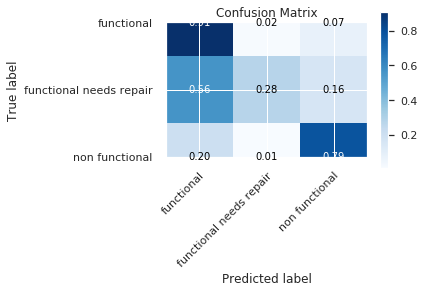

In [9]:
# Split train into train & val
train, val = train_test_split(traindf, train_size=0.80, test_size=0.20, 
                              stratify=traindf['status_group'], random_state=42)
eda.print_shape(train, val, title='After Train/Val SPLIT')

# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = testdf

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=800, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
y_pred = pipeline.predict(X_val)
eda.get_acc_rec_fone(y_val, y_pred, verbose=True, title='VAL')
y_pred = pipeline.predict(X_val)
eda.plot_confusion_matrix(y_val, y_pred, classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')


-------- TRAIN SET --------
Accuracy Score: 1.0000
                         Precision  Recall  F Score  Support
functional                     1.0     1.0      1.0    25807
non functional                 1.0     1.0      1.0     3454
functional needs repair        1.0     1.0      1.0    18259
-------- VAL SET --------
Accuracy Score: 0.8120
                         Precision    Recall   F Score  Support
functional                0.795268  0.916925  0.851775     6452
non functional            0.622024  0.242178  0.348624      863
functional needs repair   0.857978  0.771522  0.812457     4565
Normalized confusion matrix
[[0.91692498 0.01255425 0.07052077]
 [0.60950174 0.24217845 0.14831981]
 [0.21840088 0.01007667 0.77152245]]


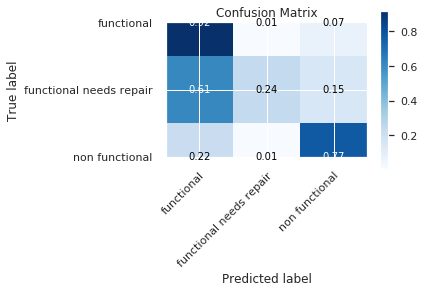

In [10]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=800, random_state=42, n_jobs=-1, class_weight='balanced')
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
y_pred = pipeline.predict(X_val)
eda.get_acc_rec_fone(y_val, y_pred, verbose=True, title='VAL')
y_pred = pipeline.predict(X_val)
eda.plot_confusion_matrix(y_val, y_pred, classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')

------- SHAPE - After Train/Val SPLIT ---------
Training Set: (47520, 41)
Validation Set: (11880, 41)
-------- TRAIN SET --------
Accuracy Score: 1.0000
                         Precision  Recall  F Score  Support
functional                     1.0     1.0      1.0    32259
non functional                 1.0     1.0      1.0     4317
functional needs repair        1.0     1.0      1.0    22824
-------- VAL SET --------
Accuracy Score: 1.0000
                         Precision  Recall  F Score  Support
functional                     1.0     1.0      1.0     6452
non functional                 1.0     1.0      1.0      863
functional needs repair        1.0     1.0      1.0     4565
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


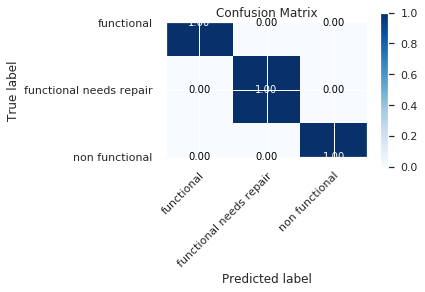

In [11]:
# Split train into train & val
train, val = train_test_split(traindf, train_size=0.80, test_size=0.20, 
                              stratify=traindf['status_group'], random_state=42)

eda.print_shape(train, val, title='After Train/Val SPLIT')

# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = traindf.drop(columns=target)
y_train = traindf[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = testdf

n_estimators = 800


pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=n_estimators,
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
y_pred = pipeline.predict(X_val)
eda.get_acc_rec_fone(y_val, y_pred, verbose=True, title='VAL')
y_pred = pipeline.predict(X_val)
eda.plot_confusion_matrix(y_val, y_pred, classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')

In [12]:
def wrangle(df, set_id_as_index=False, add_years_since=False, drop_cols=False, clean_cat_cols=False, 
            clean_num_cols=False, fix_null_island=False, 
            num_missing_value_feature=False, cat_missing_value_feature=False, convert_lat_lon=False, cut_construction_year=False):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    df = df.copy()
    
    if set_id_as_index:
        # Set `id` to be the index
        df = df.set_index('id', drop=True)
    
    if add_years_since:
        # Set correct data type for 
        ## - datetime columns
        df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True)
        df['year_recorded'] = df['date_recorded'].dt.year
        df['month_recorded'] = df['date_recorded'].dt.month
        df['day_recorded'] = df['date_recorded'].dt.day
        # Create feature
        # Add last_inspeaction_year and years_since_construction
        df['years_since'] = df['year_recorded'] - df['construction_year']
        

    if drop_cols:
        # Drop cols
        useless_columns = ['date_recorded', 'recorded_by', 'quantity_group', 'num_private', 'payment_type']
        # Remove duplicate columns and useless one
        df = df.drop(useless_columns, axis=1)
    
    if clean_cat_cols:
        # Sanitize categorical columns
        categorical_columns = eda.get_categorical_columns(df)
        nan_labels = ['unknown', 'none', '0']
        exclude_cols = ['public_meeting', 'permit']
        categorical_columns = [col for col in categorical_columns if col not in exclude_cols]
        for col in categorical_columns:
            df[col] = df[col].str.strip().str.lower()
            df[col] = df[col].replace(nan_labels, np.NaN)
    
    if fix_null_island:
        # Fix Null Island - latitudes and longitudes
        null_island = {'longitude':0, 'latitude':-2e-8}
        mask = (df['longitude'] == null_island['longitude']) & (df['latitude'] == null_island['latitude'])
        loc = 'region'
        locs = df.loc[mask, loc].unique()
        for k in null_island.keys():
            for loc_name in locs:
                df.loc[mask & (df[loc] == loc_name), k] = df[~mask].groupby(loc)[k].mean()[loc_name]
    
    if clean_num_cols:
        # Clean numerical columns
        null_placeholders = {'amount_tsh':0, 'gps_height':0, 'population':0, 'construction_year':0}
        for col, null_val in null_placeholders.items():
            df[col] = df[col].replace(null_val, np.NaN)
    
    if num_missing_value_feature:
        # Add MISSING value feature for numerical columns    
        cols_with_zeros = ['amount_tsh', 'gps_height', 'construction_year', 'years_since',
                           'population']
        for col in cols_with_zeros:
            df[col+'_MISSING'] = (df[col].isnull()).astype(int)
    
    if cat_missing_value_feature:
        # Add MISSING value feature for categorical columns
        cols_with_zeros = ['construction_year', 'years_since_construction',
                       'gps_height', 'population', 'permit', 'public_meeting']
        for col in cols_with_zeros:
            df[col+'_MISSING'] = (df[col].isnull()).astype(int)
    
    if convert_lat_lon:
        # Ways to deal with longitude/latitude feature suggested by Nick 
        # https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature
        df['x'] = np.cos(df['latitude']) * np.cos(df['longitude'])
        df['y'] = np.cos(df['latitude']) * np.sin(df['longitude'])
        df['z'] = np.sin(df['latitude'])
        
    if cut_construction_year:
        df['construction_year_bins'] = pd.cut(df['construction_year'], bins=10)
    
    # return the wrangled dataframe

    return df

In [13]:
set_id_as_index = True
add_years_since = True
drop_cols = True
clean_cat_cols = True 
clean_num_cols = True
fix_null_island = True
num_missing_value_feature = True
cat_missing_value_feature = False
convert_lat_lon = True
cut_construction_year = False

trainw = wrangle(traindf, set_id_as_index=set_id_as_index, add_years_since=add_years_since, 
                drop_cols=drop_cols, clean_cat_cols=clean_cat_cols, 
            clean_num_cols=clean_num_cols, fix_null_island=fix_null_island, 
            num_missing_value_feature=num_missing_value_feature,
                cat_missing_value_feature=cat_missing_value_feature, 
                convert_lat_lon=convert_lat_lon,
               cut_construction_year=cut_construction_year)

testw = wrangle(testdf, set_id_as_index=set_id_as_index, add_years_since=add_years_since, drop_cols=drop_cols, clean_cat_cols=clean_cat_cols, 
            clean_num_cols=clean_num_cols, fix_null_island=fix_null_island, 
            num_missing_value_feature=num_missing_value_feature,
               cat_missing_value_feature=cat_missing_value_feature, 
               convert_lat_lon=convert_lat_lon,
              cut_construction_year=cut_construction_year)

print(trainw.shape, testw.shape)
trainw.head()

(59400, 47) (14358, 46)


,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,years_since,amount_tsh_MISSING,gps_height_MISSING,construction_year_MISSING,years_since_MISSING,population_MISSING,x,y,z
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,roman,1390.0,roman,34.938093,-9.856322,NaN,lake nyasa,mnyusi b,iringa,11,5,ludewa,mundindi,109.0,True,vwc,roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,3,14,12,0,0,0,0,0,0.843332,0.337399,0.418274
8776,NaN,grumeti,1399.0,grumeti,34.698766,-2.147466,zahanati,lake victoria,nyamara,mara,20,2,serengeti,natta,280.0,NaN,other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2013,3,6,3,1,0,0,0,0,0.539805,0.076757,-0.838283
34310,25.0,lottery club,686.0,world vision,37.460664,-3.821329,kwa mahundi,pangani,majengo,manyara,21,4,simanjiro,ngorika,250.0,True,vwc,nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,2013,2,25,4,0,0,0,0,0,-0.755733,0.183697,0.628588
67743,NaN,unicef,263.0,unicef,38.486161,-11.155298,zahanati ya nanyumbu,ruvuma / southern coast,mahakamani,mtwara,90,63,nanyumbu,nanyumbu,58.0,True,vwc,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2013,1,28,27,1,0,0,0,0,0.112276,0.112647,0.987271
19728,NaN,action in a,NaN,artisan,31.130847,-1.825359,shuleni,lake victoria,kyanyamisa,kagera,18,1,karagwe,nyakasimbi,NaN,True,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2011,7,13,2011,1,1,1,0,1,-0.241658,0.070821,-0.967774


------- SHAPE - After Train/Val SPLIT ---------
Training Set: (47520, 47)
Validation Set: (11880, 47)
-------- TRAIN SET --------
Accuracy Score: 0.9980
                         Precision    Recall   F Score  Support
functional                0.996371  0.999961  0.998163    25807
non functional            0.999708  0.991025  0.995347     3454
functional needs repair   1.000000  0.996550  0.998272    18259
-------- VAL SET --------
Accuracy Score: 0.8148
                         Precision    Recall   F Score  Support
functional                0.811110  0.898481  0.852563     6452
non functional            0.567452  0.307068  0.398496      863
functional needs repair   0.848101  0.792552  0.819386     4565
Normalized confusion matrix
[[0.89848109 0.02154371 0.0799752 ]
 [0.53997683 0.30706837 0.15295481]
 [0.19364732 0.01380066 0.79255203]]


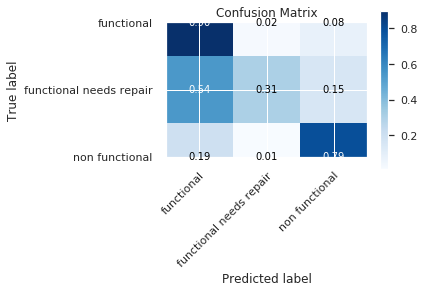

In [14]:
# Split train into train & val
train, val = train_test_split(trainw, train_size=0.80, test_size=0.20, 
                              stratify=trainw['status_group'], random_state=42)

eda.print_shape(train, val, title='After Train/Val SPLIT')

# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = testw

n_estimators = 800
min_samples_split = 10
min_samples_leaf = 2
max_features = 'sqrt'  
max_depth = 25

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(n_estimators=n_estimators,
                           max_depth=max_depth,
                           random_state=42, 
                           n_jobs=-1)
)
            
# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
y_pred = pipeline.predict(X_val)
eda.get_acc_rec_fone(y_val, y_pred, verbose=True, title='VAL')
y_pred = pipeline.predict(X_val)
eda.plot_confusion_matrix(y_val, y_pred, classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')

#kaggle_submission(pipeline, X_test, sampledf)

### Max Depth Val Curve

In [15]:
# 1. Split train into train & val
train, val = train_test_split(trainw, train_size=0.80, test_size=0.20, 
                              stratify=trainw['status_group'], random_state=42)

eda.print_shape(train, val, title='After Train/Val SPLIT')

# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = testw

eda.print_shape(X_train, X_val, X_test, title='After X/Y SPLIT')

# 2. One-hot encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)
eda.print_shape(X_train_encoded, X_val_encoded, X_test_encoded, 'After One Hot Encoding')


# 3. Simple Imputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)
eda.print_shape(X_train_imputed, X_val_imputed, X_test_imputed, 'After Simple Imputing')

# 4. Random Forest
max_depth = 25
min_depth_range = np.arange(1, max_depth, 1)
seed = 42

results = {
    'max_depth':[],
    'train_score':[],
    'val_score':[]
}


for i in max_depth_range:
    clf = RandomForestClassifier(n_estimators=800, max_depth=i, random_state=seed)
    clf.fit(X_train_imputed, y_train)
    train_score = clf.score(X_train_imputed, y_train)
    val_score = clf.score(X_val_imputed, y_val)
    results['max_depth'].append(i)
    results['train_score'].append(train_score)
    results['val_score'].append(val_score)

plt.plot(results['max_depth'], results['train_score'], label='Training Score', color='b')
plt.plot(results['max_depth'], results['val_score'], label='Validation Score', color='g')
plt.ylabel("Accuracy")
plt.xlabel("Max. Depth Random Forest")
plt.legend()
plt.title('Validation Curve for Max. Depth')
plt.show();

------- SHAPE - After Train/Val SPLIT ---------
Training Set: (47520, 47)
Validation Set: (11880, 47)
------- SHAPE - After X/Y SPLIT ---------
Training Set: (47520, 46)
Validation Set: (11880, 46)
Testing Set: (14358, 46)


MemoryError: Unable to allocate array with shape (30659, 30661) and data type int64

### Target Encoder

In [ ]:
trainw['functional'] = (trainw['status_group']=='functional').astype(int)
trainw['non functional'] = (trainw['status_group']=='non functional').astype(int)
trainw['functional needs repair'] = (trainw['status_group']=='functional needs repair').astype(int)

# Split train into train & val
train, val = train_test_split(trainw, train_size=0.80, test_size=0.20, 
                              stratify=trainw['status_group'], random_state=42)

eda.print_shape(train, val, title='After Train/Val SPLIT')

# Arrange data into X features matrix and y target vector
target = 'status_group'
exclude_cols= ['status_group', 'functional', 'non functional', 'functional needs repair']

X_train = train.drop(columns=exclude_cols)
y_train = train[target]
X_val = val.drop(columns=exclude_cols)
y_val = val[target]
X_test = testw

y_train_f = train['functional']
y_val_f = val['functional']
y_train_nf = train['non functional']
y_val_nf = val['non functional']
y_train_fr = train['functional needs repair']
y_val_fr = val['functional needs repair']

n_estimators = 800
min_samples_split = 10
min_samples_leaf = 2
max_features = 'sqrt'  
max_depth = 25

encoder = ce.TargetEncoder(min_samples_leaf=2, smoothing=2) # Both parameters > 1 to avoid overfitting
X_train_encoded_F = encoder.fit_transform(X_train, y_train_f)
X_val_encoded_F = encoder.transform(X_val, y_val=='functional')
X_train_encoded_F.head()

In [ ]:
pipeline = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_estimators=n_estimators,
                           max_depth=max_depth,
                           random_state=42, 
                           n_jobs=-1)
)
            
# Fit on train, score on val
pipeline.fit(X_train_encoded_F, y_train)
y_pred = pipeline.predict(X_train_encoded_F)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
y_pred = pipeline.predict(X_val_encoded_F)
eda.get_acc_rec_fone(y_val, y_pred, verbose=True, title='VAL')
y_pred = pipeline.predict(X_val_encoded_F)
eda.plot_confusion_matrix(y_val, y_pred, classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')

#kaggle_submission(pipeline, X_test, sampledf)

### DIRTY CAT

In [ ]:
pipeline = make_pipeline(
    SimpleImputer(),
    dirty_cat.TargetEncoder(clf_type='multiclass-clf'),
    RandomForestClassifier(n_estimators=n_estimators,
                           max_depth=max_depth,
                           random_state=42, 
                           n_jobs=-1)
)
            
# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
y_pred = pipeline.predict(X_val)
eda.get_acc_rec_fone(y_val, y_pred, verbose=True, title='VAL')
y_pred = pipeline.predict(X_val)
eda.plot_confusion_matrix(y_val, y_pred, classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')

#kaggle_submission(pipeline, X_test, sampledf)

## Exploring Random Forest 🌲 Models

### Tuning Hyper parameters

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# # Split train into train & val
# train, val = train_test_split(traindf, train_size=0.80, test_size=0.20, 
#                               stratify=traindf['status_group'], random_state=42)

# eda.print_shape(train, val, title='After Train/Val SPLIT')

# # Arrange data into X features matrix and y target vector
# target = 'status_group'
# X_train = train.drop(columns=target)
# y_train = train[target]
# X_val = val.drop(columns=target)
# y_val = val[target]
# X_test = testdf

# # 1. Encoder
# encoder = ce.OrdinalEncoder()
# X_train_encoded = encoder.fit_transform(X_train)
# X_val_encoded = encoder.transform(X_val)
# X_test_encoded = encoder.transform(X_test)


# # 2. Imputer
# imputer = SimpleImputer()
# X_train_imputed = imputer.fit_transform(X_train_encoded)
# X_val_imputed = imputer.transform(X_val_encoded)
# X_test_imputed = imputer.transform(X_test_encoded)


# # 3. Tune Hyperparameters
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# rf_model = RandomForestClassifier()
# rf_randomsearch = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_randomsearch.fit(X_train_imputed, y_train)
# print(rf_randomsearch.best_params_)

best_params = {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}

#### Just Numerical Features 🔢 w/ One-Hot Encodings + Simpute Imputer (mean) w/o MISSING FEATURE

In [ ]:
# 1. Subset features

target = 'status_group'
numeric_features_no_missing = [col for col in eda.get_numeric_columns(train) if not col.endswith('MISSING')] 
numeric_features_missing = eda.get_numeric_columns(train)
print('Numeric Features w\o Mising Feature:')
print('-'*80)
for col in numeric_features_no_missing:
    print(col)
print('Numeric Features w Mising Feature:')
print('-'*80)
for col in numeric_features_missing:
    print(col)
    
X_train, X_val, X_test, y_train, y_val = eda.subset_features(train, val, test, numeric_features_no_missing, target)
eda.print_shape(X_train, X_val, X_test, 'After Subsetting Train & Val')

In [ ]:
# 2. One-hot encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)
eda.print_shape(X_train_encoded, X_val_encoded, X_test_encoded, 'After One Hot Encoding')
X_train_encoded.head()

In [ ]:
# 3. Simple Imputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)
eda.print_shape(X_train_imputed, X_val_imputed, X_test_imputed, 'After Simple Imputing')

pd.DataFrame(data=X_train_imputed, columns=X_train.columns).head()

In [ ]:
# 4. Random Forest
clf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
clf.fit(X_train_imputed, y_train)
train_score = clf.score(X_train_imputed, y_train)
val_score = clf.score(X_val_imputed, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

X_train_encoded.head()

#### Just Numerical Features 🔢 w/ One-Hot Encodings + Simpute Imputer (mean) w/ MISSING FEATURE

In [ ]:
# 1. Subset features

X_train, X_val, X_test, y_train, y_val = eda.subset_features(train, val, test, numeric_features_missing, target)
print_shape(X_train, X_val, X_test, 'After Subsetting Train & Val')

#2. Run it to a pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names='True', handle_missing='indicator'),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit pipeline on training set & score on validation set
pipeline.fit(X_train, y_train)


train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

In [ ]:
# Check encoded columns to understand the algorithm

encoder = pipeline.named_steps['onehotencoder']
X_train_encoded = encoder.transform(X_train)
print('X_train shape after encoding', X_train_encoded.shape)
X_train_encoded.head()

#### Just Categorical Features 🆎 w/ One-Hot Encodings + Simpute Imputer (mean)

In [ ]:
# Get a series with the cardinality of the nonnumeric features

# Excludes duplicate, date, target, and useless cols
exclude_features = ['recorded_by', 'quantity_group', 'status_group', 'date_recorded']

cardinality = traindf.drop(columns=exclude_features).select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
low_card_features = cardinality[cardinality <= 50].index.tolist()
high_card_features = cardinality[cardinality > 50].index.tolist()

print('-------- Low Cardinality Features --------')
for col in low_card_features:
    print(col)
print('-------- High Cardinality Features --------')
for col in high_card_features:
    print(col)


##### - Low Cardinal Ones, 

In [ ]:
# 1. Subset low cardinality features only

# Note there are 20 cardinality features that are important predictors

target = 'status_group'
features = low_card_features
X_train, X_val, X_test, y_train, y_val = eda.subset_features(train, val, test, features, target)
eda.print_shape(X_train, X_val, X_test, 'After Subsetting Train & Val')
X_train.head()

In [ ]:
#2. Run it to a pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names='True', handle_missing='indicator'),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit pipeline on training set & score on validation set
pipeline.fit(X_train, y_train)


train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

In [ ]:
# Check encoded columns to understand the algorithm

encoder = pipeline.named_steps['onehotencoder']
X_train_encoded = encoder.transform(X_train)
print('X_train shape after encoding', X_train_encoded.shape)
X_train_encoded.head()

##### - High Cardinal Ones

In [ ]:
# 1. Now Subset high cardinality features only

target = 'status_group'
features = high_card_features
X_train, X_val, X_test, y_train, y_val = eda.subset_features(train, val, test, features, target)
print_shape(X_train, X_val, X_test, 'After Subsetting Train & Val')
X_train.head()

In [ ]:
#2. Run it to a pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names='True'),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)
# Fit pipeline on training set & score on validation set
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

#### 👍 Combined Numerical + Categorical Features w/ One-Hot Encodings + Simpute Imputer (mean) 

In [ ]:
# 1. Now subset combined features = numerical + categorical

features = numeric_features_missing + low_card_features + high_card_features
target = 'status_group'

X_train, X_val, X_test, y_train, y_val = subset_features(train, val, test, features, target)
print_shape(X_train, X_val, X_test, 'After Subsetting Train & Val')

In [ ]:
# 2. Make & Run pipelinea
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names='True'),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit pipeline on training set & score on validation set
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

In [ ]:
# Check encoded columns to understand the algorithm

encoder = pipeline.named_steps['onehotencoder']
X_train_encoded = encoder.transform(X_train)
print('X_train shape after encoding', X_train_encoded.shape)
X_train_encoded.head()

#### @ Combined Numerical + Categorical Features w/ One-Hot Encodings + Simpute Imputer (median)

In [ ]:
# 1. Subset features
features = numeric_features_missing + low_card_features + high_card_features
target = 'status_group'
X_train, X_val, X_test, y_train, y_val = eda.subset_features(train, val, test, features, target)

#2. Run it to a pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names='True'),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit pipeline on training set & score on validation set
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

#### @ Combined Numerical + Categorical Features w/ Ordinal Encodings + Simpute Imputer (mean)

In [ ]:
#2. Run it to a pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit pipeline on training set & score on validation set
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

#### @ Combined Numerical + Categorical Features w/ Ordinal Encodings + Simpute Imputer (median)

In [ ]:
# 1. Subset features
features = numeric_features_no_missing + low_card_features + high_card_features
target = 'status_group'
X_train, X_val, X_test, y_train, y_val = eda.subset_features(train, val, test, features, target)

#2. Run it to a pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names='True'),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit pipeline on training set & score on validation set
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

#### @ 